# Method Construction

The reason I'm doing this with Python is because I want to become more comfortable with the construction of many numerical approximation methods. This lab only deals with fixed timesteps.

## Contents
1. [Initial Value Problems of the First Order](#Initial-Value-Problems-of-the-First-Order)
    1. [First Order Euler Method](#First-Order-Euler-Method)
    1. [Second Order Euler Method](#Second-Order-Euler-Method)
    1. [Runge-Kutta Method](#Runge-Kutta-Method)
    1. [Method Constructors](#Method-Constructors)
1. [Second Order ODEs](#Second-Order-ODEs)
    1. [Second Order Method Constructors](#Second-Order-Method-Constructors)
    1. [Gravity](#Gravity)
1. [Generalized Constructors](#Generalized-Constructors)
    1. [Solve Function](#Solve-Function)
    1. [Euler's Constructor](#Euler's-Constructor)
    1. [RK Constructor](#RK-Constructor)
1. [Two Body Problem](#Two-Body-Problem)
    1. [N Body Problem](#N-Body-Problem)
    1. [The Lennard Jones Potential](#The-Lennard-Jones-Potential)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

## Initial Value Problems of the First Order
We will compare the accuracy of numerical approximation methods with varying timesteps.

In [2]:
# create initial conditions
df = lambda t, x: - np.power(x, 2)
initial_value = 1

# create resolution space
nn = [i for i in range(2, 10)]
ntt = [np.linspace(0, 1, n) for n in nn]
nss = [[None for _ in tt] for tt in ntt]

# create different colors for each resolution
ncolor = cm.rainbow(np.linspace(0, 1, len(nn)))

### First Order Euler Method
Consider the differential equation $\dot{x(t)} = f(t, x(t))$. The first-order Euler's method with timestep $h$ is $x' = x + hf(t, x)$, where $x'$ is the approximated value of $x$ at the incremented time $t + h$.

We consider the autonomous differential equation $\dot{x} = -x^2$, with initial condition $x(0) = 1$. Therefore, the function in question is $f(t, x) = -x^2$.

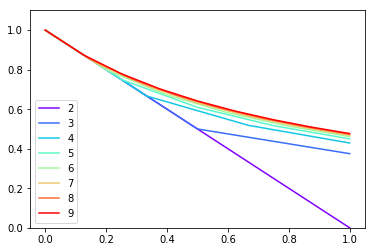

In [3]:
# iterate over different resolutions (using the first order Euler method).
for i, tt in enumerate(ntt):
    dt = (tt[-1] - tt[0]) / (len(tt) - 1)
    
    for j, t in enumerate(tt):
        if j == 0:
            nss[i][j] = initial_value
            pass
        else:
            # application of first-order euler method.
            nss[i][j] = nss[i][j-1] + df(t, nss[i][j-1])*dt
            pass
        pass
    plt.plot(tt, nss[i], label = '{}'.format(nn[i]), color = ncolor[i])
    pass
plt.ylim(0, 1.1)
plt.legend()
plt.show()

### Second Order Euler Method

Using Taylor's expansion, a second-order Euler approximation is $x' = x + h\dot{x} + \dfrac{h^2}{2}\ddot{x}$.

Since $\dot{x} = -x^2$, then $\ddot{x} = \dfrac{d}{dt}(-x^2) = -2x\dot{x} = -2x(-x^2) = 2x^3$. Let $g(t, x) = 2x^3$ be our second-order Euler function, then our approximation reduces to $x' = x - hx^2 + h^2x^3$.

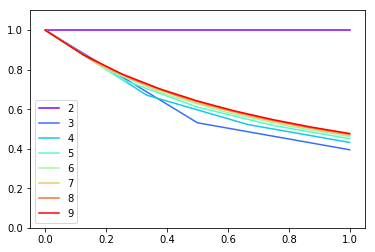

In [4]:
# define second-order term
ddf = lambda t, x:2*np.power(x, 3)

# iterate over different resolutions (using the second order Euler method).
for i, tt in enumerate(ntt):
    dt = (tt[-1] - tt[0]) / (len(tt) - 1)
    
    for j, t in enumerate(tt):
        if j == 0:
            nss[i][j] = initial_value
            pass
        else:
            # application of second-order euler method.
            nss[i][j] = nss[i][j-1] + df(t, nss[i][j-1])*dt + np.power(dt, 2)/2*ddf(t, nss[i][j-1]*dt)
            pass
        pass
    plt.plot(tt, nss[i], label = '{}'.format(nn[i]), color = ncolor[i])
    pass
plt.ylim(0, 1.1)
plt.legend()
plt.show()

### Runge-Kutta Method
The RK method states that $y' = y + \dfrac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)$, where $k_1 = hf(t_n, y_n)$, $k_2 = hf\bigg(t_n + \dfrac{h}{2}, y_n + \dfrac{k_1}{2}\bigg)$, $k_3 = hf\bigg(t_n + \dfrac{h}{2}, y_n + \dfrac{k_2}{2}\bigg)$, and $k_4 = hf(t_n + h, y_n + k_3)$.

### Method Constructors
We note that in all three approximation procedures, the method is applied in only one part of the algorithm. Hence, we can isolate the methods by defining their *constructors*, which take in all relevant functions and the timestep, and return *functions*, which take in only the current time and point in space. For our experiment, we compute all our derivatives by hand.

The purpose of writing constructors is to make as few iterated checks on the system as possible. For example, we don't need an iterated function which always checks whether a given value is an integer.

In [5]:
from scipy.special import gamma

In [6]:
def euler_method_constructor_first_order(ff):
    # computes using euler method of order equal to length of function list.
    # though we have higher orders in here, this constructor will not be used beyond this section.
    
    if not isinstance(ff, list):
        raise TypeError('ff must be list of functions.')
        pass
    
    # find order of ff.
    order = len(ff)
    
    # return a function which works for a given stepsize.
    def euler_method_stepsize_first_order(h):
        
        # return a function which, at a stepsize, returns next value.
        def euler_method_function_first_order(t, x):
            return x + sum(ff[i](t, x)*np.power(h, i + 1)/gamma(i + 1) for i in range(order))
        return euler_method_function_first_order
    return euler_method_stepsize_first_order

def runge_kutta_constructor_first_order(f):
    # constructs a function according to the rk4 algorithm.
    
    def runge_kutta_stepsize_first_order(h):
        def runge_kutta_function_first_order(t, x):
            k1 = h*f(t, x)
            k2 = h*f(t + h/2, x + k1/2)
            k3 = h*f(t + h/2, x + k2/2)
            k4 = h*f(t + h, x + k3)
            return x + 1/6*(k1 + 2*k2 + 2*k3 + k4)
        return runge_kutta_function_first_order
    return runge_kutta_stepsize_first_order

Next, we define a `solve` function, which takes in a constructor, an initial value `x_init`, a linear time array `tt`.

In [7]:
def solve_first_order(constructor, x_init, tt):
    
    # extract data from time.
    n = len(tt)
    t_min, t_max = tt[0], tt[n-1]
    h = (t_max - t_min) / (n - 1)
    
    # construct function with stepsize h.
    d_function = constructor(h)
    
    # create solution sequence.
    solution = [None for _ in range(n)]
    
    # build solutions.
    for i, t in enumerate(tt):
        if i == 0:
            solution[0] = x_init
            pass
        else:
            solution[i] = d_function(t, solution[i - 1])
            pass
        pass
    return solution

A comparison of the first-order, second-order Euler methods, and the RK4 method.

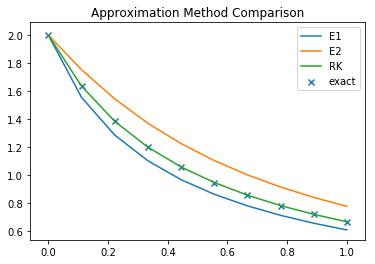

In [8]:
tt = np.linspace(0, 1, 10)
x_init = 2

euler_1 = solve_first_order(
    euler_method_constructor_first_order([lambda t, x:-np.power(x, 2)]), x_init, tt)
euler_2 = solve_first_order(
    euler_method_constructor_first_order([lambda t, x:-np.power(x, 2), lambda t, x:2*np.power(x, 3)]), x_init, tt)

rk = solve_first_order(
    runge_kutta_constructor_first_order(lambda t, x:-np.power(x, 2)), x_init, tt)
exact = x_init/(1 + x_init*tt)

for i, sol in enumerate(zip([euler_1, euler_2, rk, exact],
                            ['E1', 'E2', 'RK', 'exact'])):
    if i == 3:
        plt.scatter(tt, sol[0], label = '{}'.format(sol[1]), marker = 'x')
        pass
    elif i == 4:
        plt.scatter(tt, sol[0], label = '{}'.format(sol[1]))
    else:
        plt.plot(tt, sol[0], label = '{}'.format(sol[1]))
        pass
    pass
plt.title('Approximation Method Comparison')
plt.legend()
plt.show()

## Second Order ODEs

We consider the nonlinear, second-order ODE: $\ddot{x} = -x^2$ with initial conditions $x_0 = 1$ and $\dot{x}_0 = 1$. The solution to this ODE is nasty, and involves some ugly Weierstrass elliptic function, which we will not inspect.

We can convert the above to a system of equations. Let $\dot{x} = y$, then $\dot{y} = \ddot{x} = -x^2$. Furthermore, $y_0 = 1$.

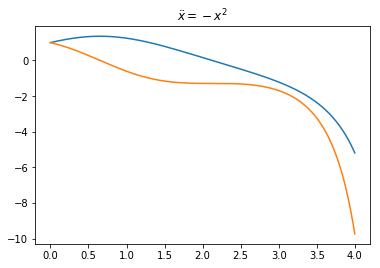

In [9]:
# basic algorithm.

# set initial conditions.
x_init, y_init = 1, 1

# construct time set.
n = 10000
t_min = 0
t_max = 4
dt = (t_max - t_min) / (n - 1)
tt = np.linspace(t_min, t_max, n)

# construct solution sets.
xx = [None for _ in range(n)]
yy = [None for _ in range(n)]

# solve for solutions.
for i in range(n):
    if i == 0:
        xx[0] = x_init
        yy[0] = y_init
        pass
    else:
        xx[i] = xx[i - 1] + yy[i - 1]*dt
        yy[i] = yy[i - 1] - xx[i - 1]**2*dt
        pass
    pass

plt.plot(tt, xx)
plt.plot(tt, yy)
plt.title('$\ddot{x} = -x^2$')
plt.show()

Similarly, the system could be solved using higher-order methods as well as Runge-Kutta.

### Second Order Method Constructors

We write second-order method constructors for both the RK and Euler's method. This time, we have two functions of two variables for our first-order euler method.

The Runge-Kutta method for solving second-order differential equation systems is referenced from [here](https://math.stackexchange.com/a/2705516/424184).

In [10]:
def euler_method_constructor_second_order(ff):
    # first order euler method.
    # ff: two functions of three variables (t, x, y).
    fx, fy = ff
    
    def euler_method_stepsize_second_order(h):
        
        def euler_method_function_second_order(t, x, y):
            x_ = x + fx(t, x, y)*h
            y_ = y + fy(t, x, y)*h
            return x_, y_
        
        return euler_method_function_second_order
    return euler_method_stepsize_second_order

def runge_kutta_constructor_second_order(ff):
    # runge-kutta method for second order system.
    # ff: two functions of three variables (t, x, y).
    fx, fy = ff
    
    def runge_kutta_stepsize_second_order(h):
        
        def runge_kutta_function_second_order(t, x, y):
            kx1 = h*fx(t, x, y)
            ky1 = h*fy(t, x, y)
            
            kx2 = h*fx(t + h/2, x + kx1/2, y + ky1/2)
            ky2 = h*fy(t + h/2, x + kx1/2, y + ky1/2)
            
            kx3 = h*fx(t + h/2, x + kx2/2, y + ky2/2)
            ky3 = h*fy(t + h/2, x + kx2/2, y + ky2/2)
            
            kx4 = h*fx(t + h, x + kx3, y + ky3)
            ky4 = h*fy(t + h, x + kx3, y + ky3)
            
            x_ = x + 1/6*(kx1 + 2*kx2 + 2*kx3 + kx4)
            y_ = y + 1/6*(ky1 + 2*ky2 + 2*ky3 + ky4)
            
            return x_, y_
        return runge_kutta_function_second_order
    return runge_kutta_stepsize_second_order

# initial conditions, time set.
def solve_second_order(constructor, initial_condition, tt):
    # extract data from tt.
    n = len(tt)
    t_min, t_max = tt[0], tt[n-1]
    h = (t_max - t_min) / (n - 1)
    
    # solve for stepsize function.
    method_function = constructor(h)
    
    # create solution sets.
    xx = [None for _ in range(n)]
    yy = [None for _ in range(n)]
    
    # solve.
    for i, t in enumerate(tt):
        if i == 0:
            xx[0], yy[0] = initial_condition
            pass
        else:
            xx[i], yy[i] = method_function(t, xx[i-1], yy[i-1])
            pass
        pass
    return xx, yy

Solving the previous system using the constructor.

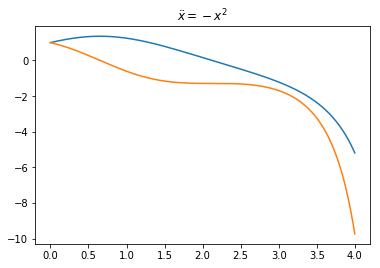

In [11]:
constructor = euler_method_constructor_second_order([lambda t, x, y: y, lambda t, x, y: -x**2])
initial_condition = [1, 1]
tt = np.linspace(0, 4, 10000)

xx, yy = solve_second_order(constructor, initial_condition, tt)
plt.plot(tt, xx)
plt.plot(tt, yy)
plt.title('$\ddot{x} = -x^2$')
plt.show()

We see that the result is the same.

In [12]:
from mpl_toolkits import mplot3d

### Gravity

A test particle with mass $\mu$ is subject to the gravitational attraction of a (fixed) source particle with mass $M$ centered at the origin. The governing law for the motion of this particle is $\mu\ddot{\mathbf{r}} = -\dfrac{G\mu M}{r^2}\hat{\mathbf{r}}$, where $\hat{\mathbf{r}} = \dfrac{\mathbf{r}}{r}$. We convert this into a system. Let $\mathbf{s} = \dot{\mathbf{r}}$, then $\dot{\mathbf{s}} = -\dfrac{G\mu M}{r^2}\hat{\mathbf{r}}$. For simplicity, we solve the system $\dot{\mathbf{r}} = \mathbf{s} = \mathbf{f}(t, \mathbf{r}, \mathbf{s})$, $\dot{\mathbf{s}} = -\dfrac{2\mathbf{r}}{r^{3/2}} = \mathbf{g}(t, \mathbf{r}, \mathbf{s})$ (The $2$ in $\mathbf{g}$ is just there to make the system more interesting).

In [13]:
# define relevant 'gravity' functions.

def f(t, r, s):
    # t is a scalar.
    # r, s are numpy arrays of length 2.
    return s

def g(t, r, s):
    r_norm = np.sqrt(r.dot(r))
    return -2/np.power(r_norm, 3/2) * r

We model a very simple system, $\mathbf{r}_0 = (1, 0)$ and $\mathbf{s}_0 = (0, 1)$. In this system, we predict that the test particle will move upwards, before the source particle's influence will drag the test particle towards it. In terms of parameters, $r_x$ decreases while $r_y$ increases, but $s_x$ becomes negative while $s_y$ is positive and decreasing. Then, the particle will probably go in some kind of orbit.

Simulating gravity with Euler's method.

In [14]:
# initial condition.
constructor = euler_method_constructor_second_order([f, g])
initial_condition = [np.array([1, 0]), np.array([0, 1])]
tt = np.linspace(0, 100, 1000)

# we expect solutions r and s to be vectors.
rr, ss = solve_second_order(constructor, initial_condition, tt)

# extract position coordinates.
xx = [r[0] for r in rr]
yy = [r[1] for r in rr]

Plotting the system in various ways.

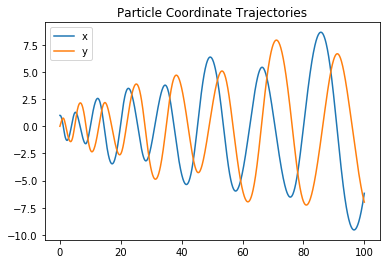

In [15]:
plt.plot(tt, xx, label = 'x')
plt.plot(tt, yy, label = 'y')
plt.legend()
plt.title('Particle Coordinate Trajectories')
plt.show()

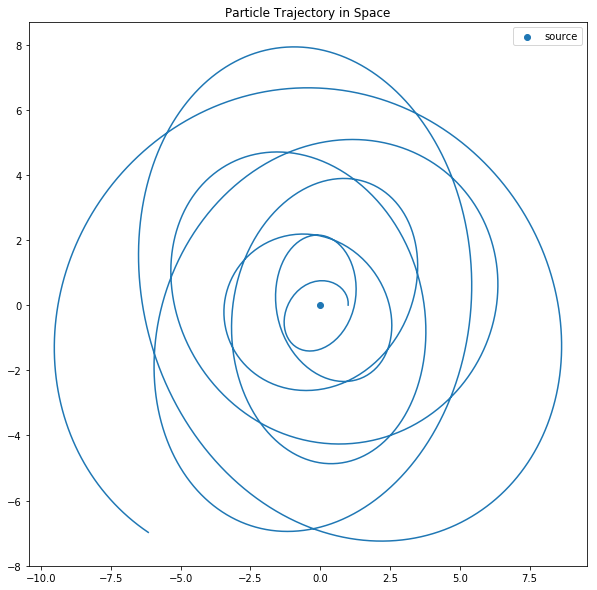

In [16]:
plt.figure(figsize = (10, 10))
plt.plot(xx, yy)
plt.scatter(0, 0, label = 'source')
plt.title('Particle Trajectory in Space')
plt.legend()
plt.show()

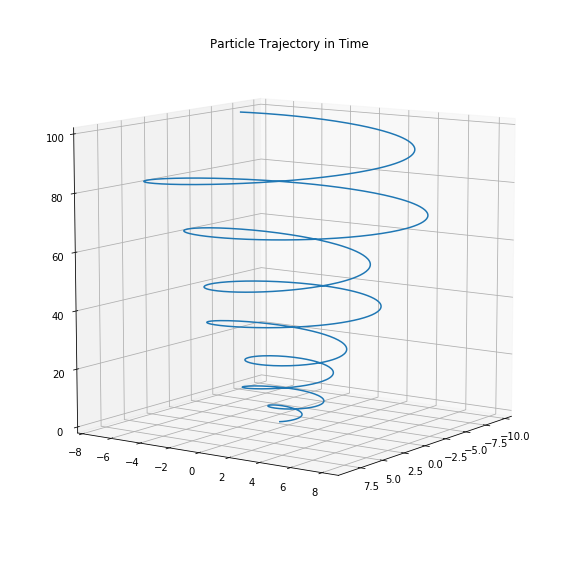

In [17]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
ax.plot3D(xx, yy, tt)
ax.view_init(10, 35)
plt.title('Particle Trajectory in Time')
plt.show()

Simulating gravity with Runge-Kutta method. (same conditions)

In [18]:
# initial condition.
constructor = runge_kutta_constructor_second_order([f, g])
initial_condition = [np.array([1, 0]), np.array([0, 1])]
tt = np.linspace(0, 100, 1000)

# we expect solutions r and s to be vectors.
rr, ss = solve_second_order(constructor, initial_condition, tt)

# extract position coordinates.
xx = [r[0] for r in rr]
yy = [r[1] for r in rr]

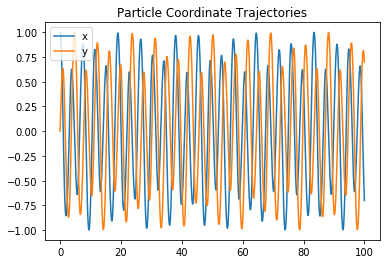

In [19]:
plt.plot(tt, xx, label = 'x')
plt.plot(tt, yy, label = 'y')
plt.legend()
plt.title('Particle Coordinate Trajectories')
plt.show()

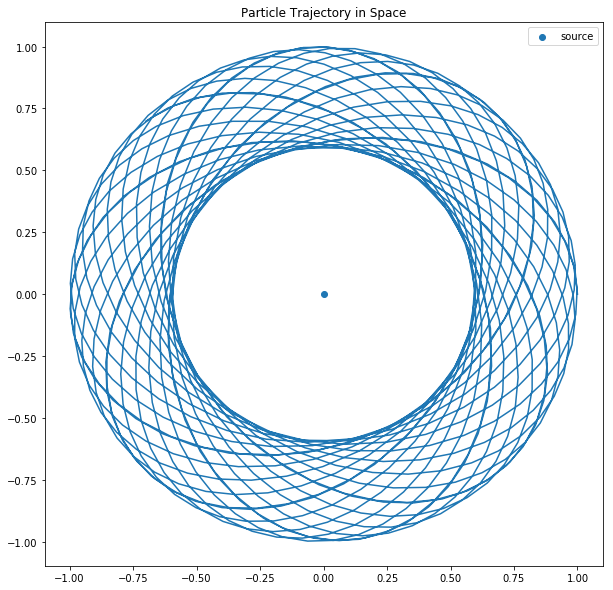

In [20]:
plt.figure(figsize = (10, 10))
plt.plot(xx, yy)
plt.scatter(0, 0, label = 'source')
plt.title('Particle Trajectory in Space')
plt.legend()
plt.show()

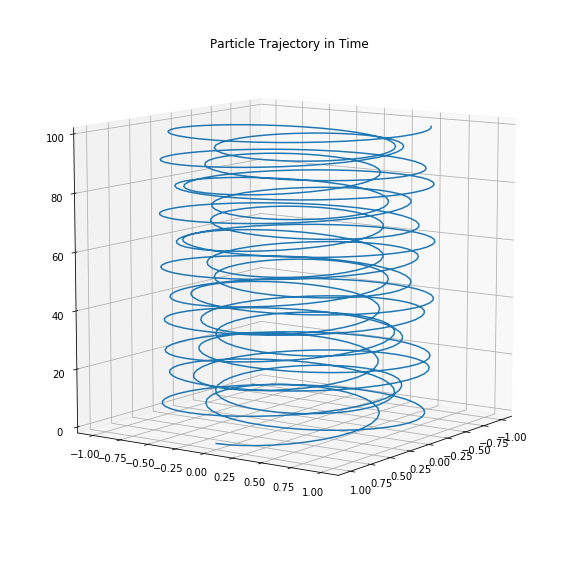

In [21]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
ax.plot3D(xx, yy, tt)
ax.view_init(10, 35)
plt.title('Particle Trajectory in Time')
plt.show()

We see that the RK method is more accurate than Euler's method, when the timesteps are the same.

## Generalized Constructors

Consider the system of differential equations, $\dot{\mathbf{x}} = \mathbf{F}(t, \mathbf{x})$, where $\mathbf{x}\in\mathbb{R}^n$ and $\mathbf{F}:\mathbb{R}^{n+1}\to\mathbb{R}^n$ are vectors and vectors of functions, respectively, i.e. $\mathbf{F} = (F_1, F_2, \cdots, F_n)$ and $F_i:\mathbb{R}^{n+1}\to\mathbb{R}$ for all valid $i$.

To make sure all constructors do what they are told, we define what a constructor is below.

**Constructor**: Let $\mathbf{F}:\mathbb{R}^{n+1}\to\mathbb{R}^n$ be a vector function of $t$ and $\mathbf{x}$. A constructor of stepsize $h$, $\mathcal{C}_h(\mathbf{F}):\mathbb{R}\to(\mathbb{R}^{n+1}\to\mathbb{R}^n)$ returns a timestep-dependent method function which returns the next iteration of a solution based on the method chosen.

In the algorithm, the `constructor` function takes in a list of functions `ff`, such that each function `f` in `ff` has a scalar argument `t`, and a vector argument `x` of length $n$, equal to the order of the differential equation system.

The `constructor` function returns a `stepsize` function: an intermediate function which, given a stepsize `h`, returns the next iteration of a solution: `x_ = stepsize(h)(t, x)`.

### Solve Function

`solve` is a vector-oriented function which takes a specific method constructor (e.g. `euler_method_constructor(ff)`), vector initial conditions `initial_conditions`, and a linear timespace `tt`. It returns the solution space `[xx1, xx2, ..., xxn]`. It is normally independent of what construction is used, as long as the constructor is vectorized.

In [22]:
def solve(constructor, initial_condition, tt):
    # extract data from tt.
    n = len(tt)
    t_min, t_max = tt[0], tt[n-1]
    h = (t_max - t_min) / (n - 1)
    
    # method function.
    method_function = constructor(h)
    
    # create vector solution set.
    solution = [None for _ in range(n)]
    
    # compute solutions.
    for i, t in enumerate(tt):
        if i == 0:
            solution[0] = initial_condition
            pass
        else:
            solution[i] = method_function(t, solution[i-1])
            pass
        pass
    return solution

### Euler's Constructor

We may generalize Euler's method for single functions to multiple functions: $\mathbf{x}' = \mathbf{x} + h\mathbf{F}(t, \mathbf{x})$, where $h$ is some fixed timestep.

In [23]:
# supplementary function: returns vectorized version of a list of functions.
# distinguished from the rest of the code to provide some intuition on how the function is vectorized.
def vectorize(ff):
    def vectorized_function(t, x):
        # the problem with this function is that every element in x must have equal dimensions.
        
        return np.array([f(t, x) for f in ff])
    return vectorized_function

def euler_method_constructor(ff):
    # ff: a list of functions for each entry in a vector differential equation.
    # The order of the differential equation is the length of ff and denoted n.
    # The number of arguments in each function of ff must be equal to (n+1).
    
    vectorized_function = vectorize(ff)
    
    def euler_method_stepsize(h):
        def euler_method_function(t, x):
            
            return x + vectorized_function(t, x)*h
        return euler_method_function
    return euler_method_stepsize

Vector notation greatly helps in shortening the required code.

In [24]:
ff = [lambda t, xx:xx[1], lambda t, xx:-xx[0]**2]
initial_condition = np.array([1, 1])
tt = np.linspace(0, 4, 10000)

constructor = euler_method_constructor(ff)

solution = solve(constructor, initial_condition, tt)

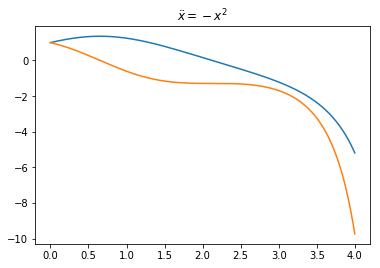

In [25]:
xx = [s[0] for s in solution]
yy = [s[1] for s in solution]
plt.plot(tt, xx)
plt.plot(tt, yy)
plt.title('$\ddot{x} = -x^2$')
plt.show()

### RK Constructor

In a vectorized Runge-Kutta construction, we have $\mathbf{x}' = \mathbf{x} + \dfrac{1}{6}(\mathbf{k}_1 + 2\mathbf{k}_2 + 2\mathbf{k}_3 + \mathbf{k}_4)$, where

> $\mathbf{k}_1 = h\mathbf{F}(t, \mathbf{x})$,
>
> $\mathbf{k}_2 = h\mathbf{F}(t + h/2, \mathbf{x} + \mathbf{k}_1/2)$,
>
> $\mathbf{k}_3 = h\mathbf{F}(t + h/2, \mathbf{x} + \mathbf{k}_2/2)$,
>
> $\mathbf{k}_4 = h\mathbf{F}(t + h, \mathbf{x} + \mathbf{k}_3)$.

In [26]:
def runge_kutta_constructor(ff):
    # vectorize function.
    vectorized_function = vectorize(ff)
    
    def runge_kutta_stepsize(h):
        def runge_kutta_method(t, x):
            
            k1 = h*vectorized_function(t, x)
            k2 = h*vectorized_function(t + h/2, x + k1/2)
            k3 = h*vectorized_function(t + h/2, x + k2/2)
            k4 = h*vectorized_function(t + h, x + k3)
            
            return x + 1/6*(k1 + 2*k2 + 2*k3 + k4)
        return runge_kutta_method
    return runge_kutta_stepsize

We vectorize functions previously defined in gravity.

In [27]:
def velocity(t, x):
    r, v = x
    return v

def acceleration(t, x):
    r, v = x
    r_norm = np.sqrt(r.dot(r))
    return -2/np.power(r_norm, 3/2) * r

Resolve the gravity problem.

In [28]:
# set up the problem.
constructor = runge_kutta_constructor([velocity, acceleration])
initial_condition = [np.array([1, 0]), np.array([0, 1])]
tt = np.linspace(0, 100, 1000)

In [29]:
solution = solve(constructor, initial_condition, tt)
rr = [s[0] for s in solution]
xx = [r[0] for r in rr]
yy = [r[1] for r in rr]

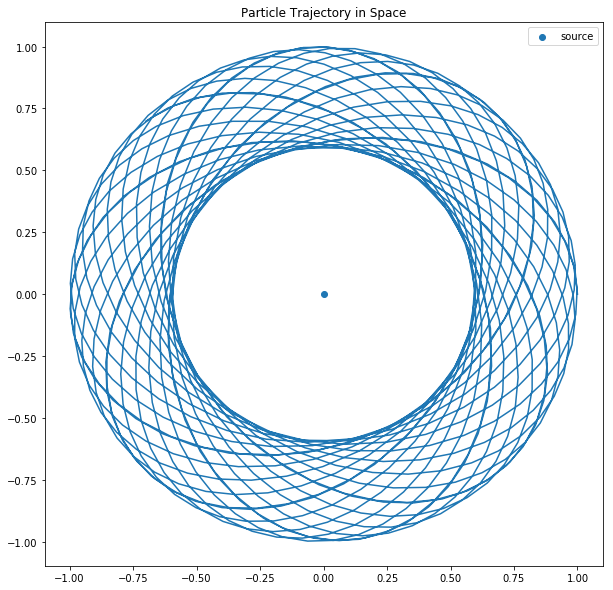

In [30]:
plt.figure(figsize = (10, 10))
plt.plot(xx, yy)
plt.scatter(0, 0, label = 'source')
plt.title('Particle Trajectory in Space')
plt.legend()
plt.show()

## Two Body Problem

The two-body problem is a famous problem in physics, and we're going to approach it naively with the tools we've developed and gained fluency with, primarily using Runge-Kutta methods on the equations of motion which govern two moving particles.

*Initial conditions*. Consider two particles $a$ and $b$ with equal mass, with initial positions $\mathbf{q}_{a, 0} = (1, 0)^T$, $\mathbf{q}_{b, 0} = (-1, 0)^T$, and initial velocities $\mathbf{p}_{a, 0} = (-1, 1)$, $\mathbf{p}_{b, 0} = (1, -1)$. This system is rotationally symmetric, in which particle $a$ moves upleft, before being pulled downwards by $b$, and particle $b$ moves downright, before being pulled upwards by $a$, and they proceed in symmetric orbits around each other.

Unlike in the previous gravity problem where the second point is fixed, here we have to account for changes in distance between the two points by taking the norm. The equations of motion governing a two-body system is

> $\dot{\mathbf{q}_a} = \mathbf{p}_a$
>
> $\dot{\mathbf{q}_b} = \mathbf{p}_b$
>
> $\dot{\mathbf{p}_a} = -\dfrac{2}{r^{3/2}}(\mathbf{q}_b - \mathbf{q}_a)$
>
> $\dot{\mathbf{p}_b} = -\dfrac{2}{r^{3/2}}(\mathbf{q}_a - \mathbf{q}_b) = -\dot{\mathbf{p}_a}$,

by Newton's second law.

(not working right now) Since recalculating the momentum for $b$ is inefficient. We solve this inefficiency by letting $\mathbf{P} = (\mathbf{p}_a, \mathbf{p}_b)^T$, so that the above two equations become

$$\dot{\mathbf{P}} = \Big(-\dfrac{2}{r^{3/2}}(\mathbf{q}_b - \mathbf{q}_a), -\dot{\mathbf{p}_a}\Big)^T.$$

In setting up our system, we will describe positions first and momenta second, so our order of solutions will always be: `[qa, qb], [pa, pb]`, and the list containing these vectors is our solution `state`.

In [31]:
# define the system functions.
def qa_dot(t, state):
    return state[2]

def qb_dot(t, state):
    return state[3]

def pa_dot(t, state):
    # return numpy array [pa_dot, pb_dot]
    qa, qb, pa, pb = state
    
    # calculate pa
    r = qa - qb
    r_norm = np.sqrt(r.dot(r))
    pa_ = -2/np.power(r_norm, 3/2)*r
    return pa_

def pb_dot(t, state):
    qa, qb, pa, pb = state
    
    # calculate pa
    r = qb - qa
    r_norm = np.sqrt(r.dot(r))
    pb_ = -2/np.power(r_norm, 3/2)*r
    return pb_

In [32]:
# set up problem.
ff = [qa_dot, qb_dot, pa_dot, pb_dot]
constructor = runge_kutta_constructor(ff)
initial_condition = [
    np.array([1, 0]), # initial qa value.
    np.array([-1, 0]), # initial qb value.
    np.array([-1, 1]),
    np.array([1, -1])
]

tt = np.linspace(0, 100, 10000)

In [33]:
# compute data.
solution = solve(constructor, initial_condition, tt)

# retrieve information.
qqa = [s[0] for s in solution]
qqb = [s[1] for s in solution]

xxa = [q[0] for q in qqa]
yya = [q[1] for q in qqa]

xxb = [q[0] for q in qqb]
yyb = [q[1] for q in qqb]

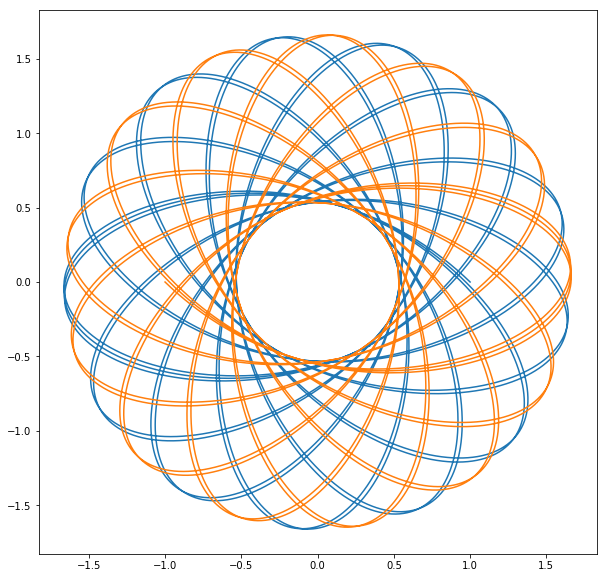

In [34]:
plt.figure(figsize = (10, 10))
plt.plot(xxa, yya)
plt.plot(xxb, yyb)
plt.show()

Is it possible to make our algorithm more efficient with Newton's laws?

In [35]:
# using only two state vectors, q and p.

def q_dot(t, state):
    return state[1]

def p_dot(t, state):
    q = state[0]
    qa, qb = q[:2], q[2:]
    r = qa - qb
    r_norm = np.sqrt(r.dot(r))
    pa_ = -2/np.power(r_norm, 3/2)*r
    return np.array([pa_, -pa_]).flatten()

In [36]:
ff = [q_dot, p_dot]
constructor = runge_kutta_constructor(ff)
initial_condition = [
    np.array([1, 0, -1, 0]), # initial q value.
    np.array([-1, 1, 1, -1]), # initial p value
]

tt = np.linspace(0, 100, 10000)

In [37]:
# compute data.
solution = solve(constructor, initial_condition, tt)

In [38]:
# extract data
qq = [s[0] for s in solution]
xxa = [q[0] for q in qq]
yya = [q[1] for q in qq]
xxb = [q[2] for q in qq]
yyb = [q[3] for q in qq]

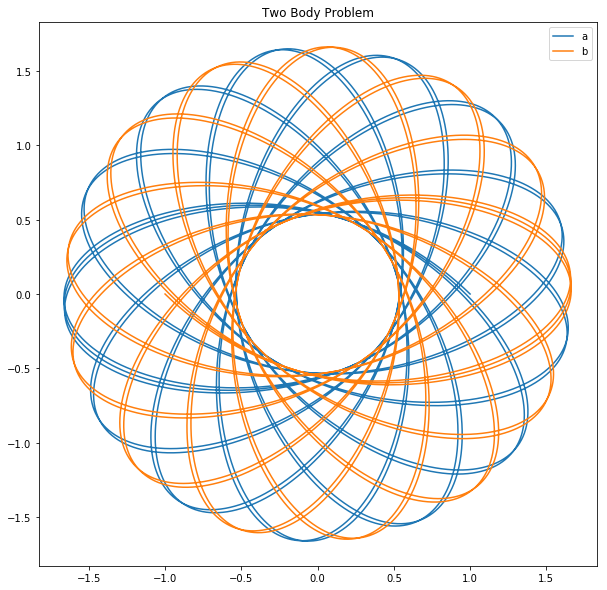

In [39]:
plt.figure(figsize = (10, 10))
plt.plot(xxa, yya, label = 'a')
plt.plot(xxb, yyb, label = 'b')
plt.title('Two Body Problem')
plt.legend()
plt.show()

### N Body Problem

In the equations of motion for an $N$-body system with equal mass particles, the changes we make to $\dot{\mathbf{q}}$ are rather straightfoward.

For $\dot{\mathbf{p}} = (\mathbf{p}_1, \cdots, \mathbf{p}_n)$, we have $\dot{\mathbf{p}_i} = \sum\limits_{j\neq i}^n(-2)\dfrac{\mathbf{r}_{ji}}{r_{ji}^{3/2}}$

In [40]:
def q_dot(t, state):
    return state[1]

def norm(r):
    r_norm = np.sqrt(r.dot(r))
    return r_norm

def p_dot(t, state):
    q, p = state
    n = len(q) # number of coordinates.
    m = int(n/2) # number of particles.
    
    # reorganize.
    qq = [q[i:i+2] for i in range(0, n, 2)]
    
    # create momentum space.
    pp = [None for i in range(m)]
    
    # compute momenta.
    for i in range(m):
        jj = list(filter(lambda j:j!=i, range(m)))
        
        forces = np.array([(-2)*(qq[i]-qq[j])/np.power(norm(qq[i]-qq[j]),3/2) for j in jj]).sum(axis = 0)
        pp[i] = forces
        pass
    return np.array(pp).flatten()

In [41]:
ff = [q_dot, p_dot]
constructor = runge_kutta_constructor(ff)
initial_condition = [
    np.array([1, 1, 0, 1, -1, -1, 1, -1]), # initial q value.
    np.array([0, 0, 0, 0, 0, 0, 0, 0]), # initial p value
]

tt = np.linspace(0, 10, 1000)

In [42]:
solution = solve(constructor, initial_condition, tt)

In [43]:
# extract data
qq = [s[0] for s in solution]
xxa = [q[0] for q in qq]
yya = [q[1] for q in qq]
xxb = [q[2] for q in qq]
yyb = [q[3] for q in qq]
xxc = [q[4] for q in qq]
yyc = [q[5] for q in qq]
xxd = [q[6] for q in qq]
yyd = [q[7] for q in qq]

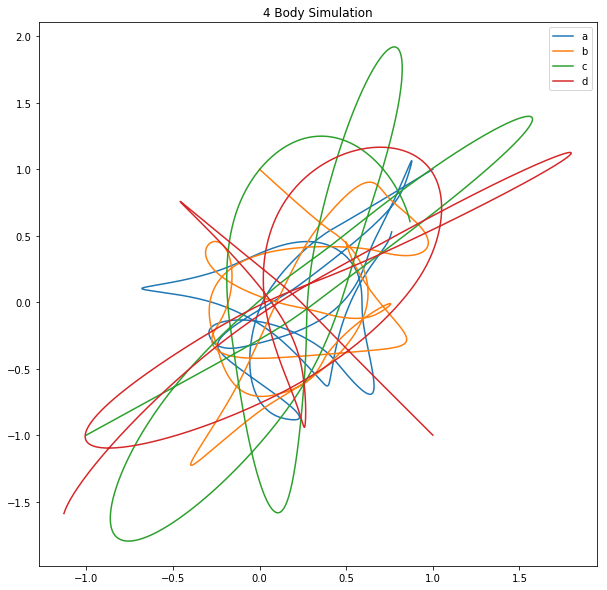

In [44]:
plt.figure(figsize = (10, 10))
plt.plot(xxa, yya, label = 'a')
plt.plot(xxb, yyb, label = 'b')
plt.plot(xxc, yyc, label = 'c')
plt.plot(xxd, yyd, label = 'd')
plt.title('4 Body Simulation')
plt.legend()
plt.show()

### The Lennard Jones Potential

The Lennard Jones (LJ) potential which approximates the interaction between a pair of neutral atoms or molecules (Wikipedia). The simplified LJ potential is $\phi_\mathrm{LJ}(R) = 4[R^{-12} - R^{-6}]$.

In [45]:
def lennard_jones_potential(r):
    return 4*(np.power(r, -12) - np.power(r, -6))

In [46]:
rr = np.linspace(1, 3, 100)
solution = lennard_jones_potential(rr)

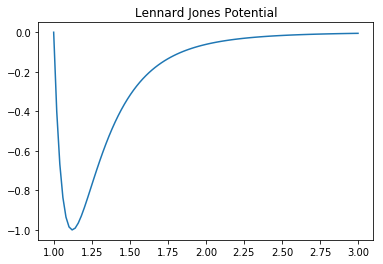

In [47]:
plt.plot(rr, solution)
plt.title('Lennard Jones Potential')
plt.show()

The equations of motion for an $N$-body system under the Lennard-Jones potential is

> $\dfrac{m\sigma^2}{\epsilon}\dfrac{d^2\mathbf{q}_i}{dt^2} = -\sum\limits_{j\neq i}^N\dfrac{\phi_\mathrm{LJ}(r_{ij})}{r_{ij}}(\mathbf{q}_i - \mathbf{q}_j)$,

and its simplified form is

> $\dfrac{d^2\mathbf{Q}}{d\tau^2} = -\sum\limits_{j\neq i}^N\dfrac{\phi'_\mathrm{LJ}(R_{ij})}{R_{ij}}(\mathbf{Q}_i - \mathbf{Q}_j)$

where $\mathbf{Q} = \sigma^{-1}\mathbf{q}$. Let $\dot{\mathbf{Q}} = \mathbf{P}$, then $\dot{\mathbf{P}} = \ddot{\mathbf{Q}}$.

In [48]:
# lennard jones n body system functions.
# the default is in two dimensions.

def q_dot(t, state):
    # t is a scalar,
    # state = [q, p].
    return state[1]

def p_dot(t, state):
    q = state[0]
    
    n = len(q)
    # separate q 
    qq = [q[i:i+2] for i in range(0, n, 2)]
    m = len(qq)
    
    # create momentum space.
    pp = [None for i in range(m)]
    
    # compute momenta.
    for i in range(m):
        jj = list(filter(lambda j:j!=i, range(m)))
        
        # abbreviate lennard jones potential.
        lj = lennard_jones_potential
        forces = np.array([(-1)*lj(norm(qq[i] - qq[j]))/(norm(qq[i] - qq[j]))*(qq[i] - qq[j]) for j in jj]).sum(axis = 0)
        pp[i] = forces
        pass
    return np.array(pp).flatten()

In [49]:
constructor = runge_kutta_constructor([q_dot, p_dot])

def simulate_lj_system(initial_condition, tt):
    solution = solve(constructor, initial_condition, tt)
    
    qq = [s[0] for s in solution]
    qxa = [q[0] for q in qq]
    qya = [q[1] for q in qq]
    qxb = [q[2] for q in qq]
    qyb = [q[3] for q in qq]
    
    plt.plot(qxa, qya, label = 'a')
    plt.plot(qxb, qyb, label = 'b')
    plt.legend()
    pass

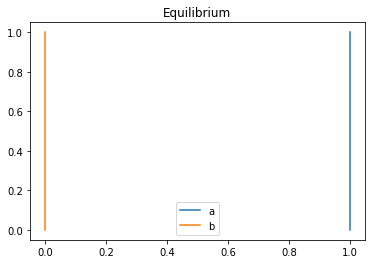

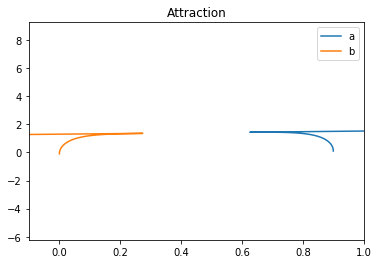

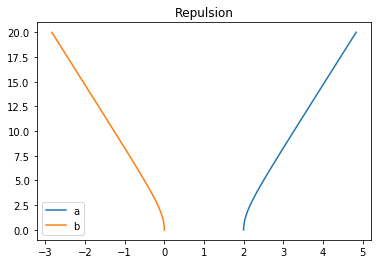

In [50]:
simulate_lj_system([
    np.array([1, 0, 0, 0]),
    np.array([0, 1, 0, 1])
], np.linspace(0, 1, 100))
plt.title('Equilibrium')
plt.show()

simulate_lj_system([
    np.array([.9, .1, 0, -.1]),
    np.array([0, 8, 0, 8])
], np.linspace(0, .19, 100))
plt.title('Attraction')
plt.xlim(-.1, 1)
plt.show()

simulate_lj_system([
    np.array([2, 0, 0, 0]),
    np.array([0, 1, 0, 1])
], np.linspace(0, 20, 100))
plt.title('Repulsion')
plt.show()